#  Stochastic Segmentation Networks: Modelling Spatially Correlated Aleatoric Uncertainty

Monteiro et al. 2020, accepted at NeurIPS 2020.

![caption](files/covmat.png)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm.notebook as tqdm

plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [2]:
MARGIN = 8
DIM = 32

rng = np.random.RandomState(7)

def build_input(batch_size, shape):
    h, w = shape
    img = np.ones((batch_size, h, w), dtype=np.float32) + 0.5*rng.randn(h, w)
    line_pos = rng.randint(0, h - MARGIN - 1, size=batch_size)
    for i, lp in enumerate(line_pos):
        img[i, lp:lp+MARGIN] = 0.9*rng.randn(MARGIN, w)
        img[i, :lp] = -1.0 + 0.5*rng.randn(lp, w)
    return img.astype(np.float32), line_pos

def build_output(inp, line_pos):
    batch_size = inp.shape[0]
    offsets = line_pos
    output = np.zeros_like(inp)
    line_pos = rng.randint(0, MARGIN, size=batch_size) + offsets
    for i, lp in enumerate(line_pos):
        output[i, lp:] = 1.0
    return output.astype(np.float32)

def produce_data(batch_size, dim):
    while True:
        xs, line_pos = build_input(batch_size, (dim, dim))
        ys = build_output(xs, line_pos)
        yield np.expand_dims(xs, 1), np.expand_dims(ys, 1)
        
def plot_im(xs, cmap, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    xs = xs.squeeze().T[:16]
    ax.imshow(xs, cmap, interpolation="none")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=40, pad=20)

def sample_bernoulli_im(im, n_samples=1):
    im = np.concatenate([1 - im, im], axis=1)[0].transpose(1, 2, 0)
    n_ims = np.tile(im[None, ...], [n_samples, 1, 1, 1])
    sample = (n_ims.cumsum(-1) >= rng.uniform(size=n_ims.shape[:-1])[..., None]).argmax(-1)
    return sample

In [3]:
inp, lp = build_input(1, (DIM, DIM))
out = np.concatenate([build_output(inp, lp) for _ in range(100)], axis=0)

## Some data is messy 

For the same image $x$ we have multiple ambigous labels $y_{1,2,\dots}$.

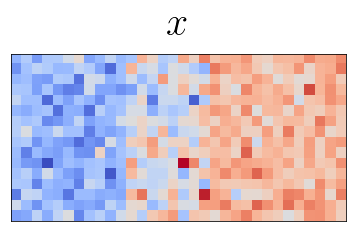

In [4]:
plot_im(inp[0], cmap="coolwarm", title=r"$$x$$")

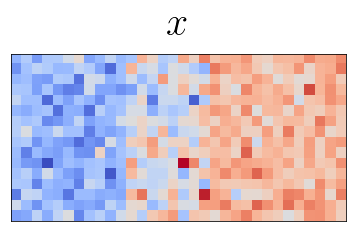

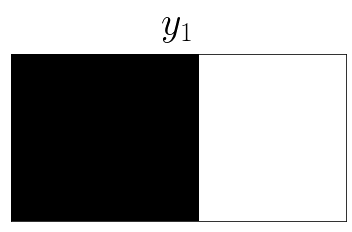

In [5]:
plot_im(inp[0], cmap="coolwarm", title=r"$$x$$")
plot_im(out[0], cmap="gray", title=r"$$y_1$$")

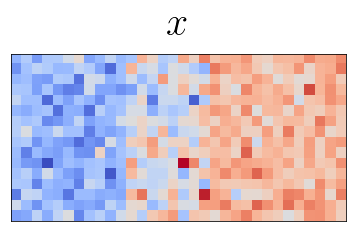

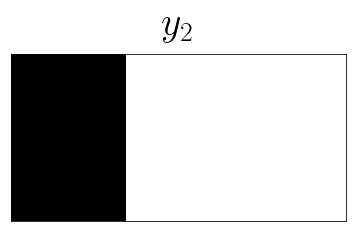

In [6]:
plot_im(inp[0], cmap="coolwarm", title=r"$$x$$")
plot_im(out[4], cmap="gray", title=r"$$y_2$$")

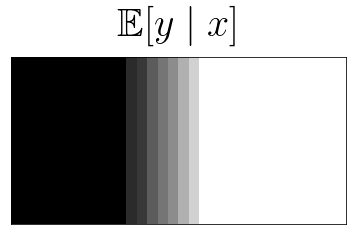

In [7]:
plot_im(out.mean(0), cmap="gray", title=r"$$\mathbb{E}[y \mid x]$$")

## Probabilistic perspective

#### Typical modelling approach:

 * Assume an underlying data distribution $p(y \mid x)$,
 * construct a parametric model: $p_\phi(y \mid x) = \int p(y \mid \phi) p(\phi \mid x)d\phi$,
 * optimise $\phi$ to minimise a divergence between $p$ and $p_\phi$.

#### Simplifications:

 * Model only an "output" variable $\eta$ (e.g. the logits before softmax);
     - the model becomes $p_\phi(y \mid x) = \int p(y \mid \eta) p_\phi(\eta \mid x)d\eta$
 * set $p_\phi(\eta \mid x)$ to be a delta function, i.e. $\eta = f_\phi(x)$ is deterministic
     - the integral reduces to the likelihood: $p_\phi(y \mid x) = p(y \mid f_\phi(x))$
 * set $p(y \mid f_\phi(x))$ to be a factorised categorical distribution
 * optimise KL-divergence between $p$ and $p_\phi$ using MC approximation:
 
 Using these assumptions, we can derive an easy to implement model:
 
 
 $$
 \begin{align}
 &\text{argmin}_\phi D_\text{KL}\left(p(y \mid x) \mid\mid p(y \mid f_\phi(x))\right) \\
 &= \text{argmin}_\phi \int p(y \mid x) \log{\frac{p(y \mid x)}{p(y \mid f_\phi(x)))}} \\
 &= \text{...steps left as an exercise to the reader...} \\
 &\approx \text{argmin}_\phi -\frac{1}{N}\sum_{n,i,c}y^n_{i,c}\log{\text{softmax}(f_\phi(x^n))_{i,c}},\quad (x^n, y^n) \sim p(x, y) \quad \text{for} \, n=1, 2, \dots, N
 \end{align}
 $$
 
 **For a good solution $\phi^*$ we will have $p(y_i \mid f_{\phi^*}(x)_i) = p(y_i \mid x)$**

![caption](files/gm_det.png)

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, inp_size, n_hidden):
        super(MLP, self).__init__()
        self.layers = [torch.nn.Linear(inp_size, n_hidden[0])]
        for cur, nxt in zip(n_hidden, n_hidden[1:]): 
            self.layers.append(torch.nn.Linear(cur, nxt))
        self.layers.append(torch.nn.Linear(n_hidden[-1], inp_size))
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, xs, as_probs=False):
        orig_shape = xs.shape
        out = xs.view(xs.shape[0], -1)
        for layer in self.layers[:-1]:
            out = torch.nn.functional.relu(layer(out))
        out = self.layers[-1](out)
        if as_probs:
            out = torch.sigmoid(out)
        return out.view(*orig_shape)
    
    def log_likelihood(self, xs, ys):
        params = self.forward(xs)
        logprobs = torch.distributions.Bernoulli(logits=params).log_prob(ys).sum((1, 2, 3))
        return logprobs

In [9]:
def run_step(xs_t, ys_t, opt, net):
    opt.zero_grad()
    loss = -torch.mean(net.log_likelihood(xs_t, ys_t))
    loss.backward()
    opt.step()
    return loss.detach().numpy()

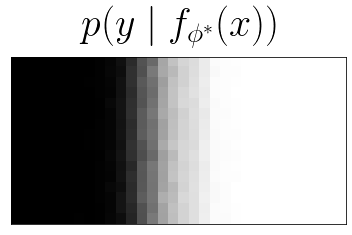

In [25]:
producer = produce_data(10, DIM)
net = MLP(inp_size=DIM*DIM, n_hidden=[64, 64, 64])
opt = torch.optim.Adam(net.parameters(), lr=3e-4)

N_ITERS = 1000
pbar = tqdm.tqdm(range(N_ITERS))

for i in pbar:
    xs, ys = next(producer)
    xs_t = torch.as_tensor(xs)
    ys_t = torch.as_tensor(ys)
    loss = run_step(xs_t, ys_t, opt, net)
    pbar.set_description_str(f"loss: {loss:4.2f} ")

ys_pred = net(torch.as_tensor(inp[:, None, ...]), as_probs=True).detach().numpy()
plot_im(ys_pred[0], cmap="gray", title=r"$$p(y \mid f_{\phi^*}(x))$$")

* What we see is a distribution, not a sample from it.  
* We can obtain a useful sample by applying argmax/thresholding operation (mode extraction)

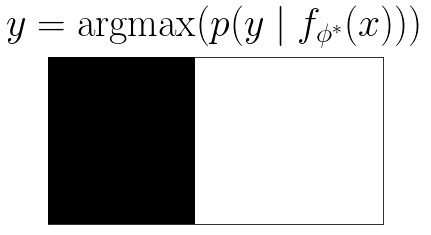

In [11]:
plot_im(ys_pred[0] > 0.5, cmap="gray", title=r"$$y = \mathrm{argmax}(p(y \mid f_{\phi^*}(x)))$$")

* Alternatively we can also sample from $p(y \mid f_{\phi^*}(x))$ at the cost of label inconsistencies.

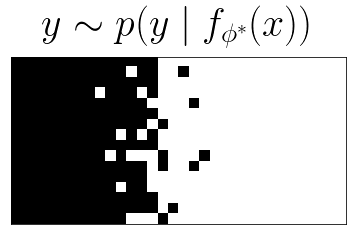

In [12]:
fd_sample = sample_bernoulli_im(ys_pred)
plot_im(fd_sample, cmap="gray", title=r"$$y \sim p(y \mid f_{\phi^*}(x))$$")

## Modelling dependence in $y$

Before:
![caption](files/gm_det.png) 

Now:
![caption](files/gm_sto.png)

#### Complications:

 Discard two simplifying assumptions of the older model:
 1. Logits are independent
 2. $p(\eta \mid x)$ is a delta function

Both can be tackled by letting $p(\eta \mid x) = \mathcal{N}\left(\eta \mid \mu(x), \Sigma(x)\right)$

However, $\Sigma(x)$ will become intractable if one has to model all $\frac{1}{2}(H\times W\times C)^2$ correlations!

Introduce low-rank parameterisation for $\Sigma = PP^T + D$ where $P\in \mathbb{R}^{(H\times W\times C)\times R}$ and $R \ll H\times W\times C$.

$R$ is a hyperparameter controlling the rank of the covariance factor matrix $P$ and $D$ is a diagonal matrix.

This modifies the objective slightly:

* the model becomes $p_\phi(y \mid x) = \int p(y \mid \eta) \mathcal{N}\left(\eta \mid \mu(x),\Sigma(x)\right)d\eta \approx \frac{1}{M}\sum_i p(y \mid \eta_i),\quad \eta_i \sim \mathcal{N}\left(\mu(x),\Sigma(x)\right)$
$$
\begin{align}
&\text{argmin}_\phi -\frac{1}{N}\sum_{n,i,c}y^n_{i,c}\log{\text{softmax}(\underset{\eta^n}{\underbrace{f_\phi(x^n)}})_{i,c}},\quad (x^n, y^n) \sim p(x, y)\\
&\rightarrow \text{argmin}_\phi -\frac{1}{N}\sum_n \log{\left(\frac{1}{M}\sum_j\exp{\left(\sum_{i,c}y^n_{i,c}\log{\text{softmax}\left(\eta^n_j\right)_{i,c}}\right)}\right)},\quad \eta^n\sim \mathcal{N}\left(\mu(x^n), \Sigma(x^n)\right);\quad (x^n, y^n) \sim p(x, y)
\end{align}
$$

Lastly, we need to learn $\mu(x)$ and $\Sigma(x)$. Apply reparametrisation trick:

$$
\eta \sim \mathcal{N}\left(\mu(x), \Sigma(x)\right) \iff \mu(x) + \sqrt{\Sigma(x)}\epsilon,\quad \epsilon \sim \mathcal{N}\left(0, I\right)
$$

In [13]:
class StochasticMLP(torch.nn.Module):
    def __init__(self, inp_size, n_hidden, cov_factor=1):
        super(StochasticMLP, self).__init__()
        self.cov_factor = cov_factor
        self.layers = [torch.nn.Linear(inp_size, n_hidden[0])]
        for cur, nxt in zip(n_hidden, n_hidden[1:]): 
            self.layers.append(torch.nn.Linear(cur, nxt))
        self.mu = torch.nn.Linear(n_hidden[-1], inp_size)
        self.P = torch.nn.Linear(n_hidden[-1], inp_size*cov_factor)
        self.D = torch.nn.Linear(n_hidden[-1], inp_size)
        self.layers.extend([self.mu, self.P, self.D])
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, xs, as_probs=False, n_samples=1, use_mode=False):
        out = xs.view(xs.shape[0], -1)
        for layer in self.layers[:-3]:
            out = torch.nn.functional.relu(layer(out))
        if not use_mode:
            cov_factor = self.P(out).view(xs.shape[0], -1, self.cov_factor)
            cov_diag = torch.exp(self.D(out)) + 1e-3
            out = torch.distributions.LowRankMultivariateNormal(
                self.mu(out), cov_factor, cov_diag
            ).rsample((n_samples,)).permute(1, 0, 2)
        else:
            out = self.mu(out)
        if as_probs:
            out = torch.sigmoid(out)
        return out.view(xs.shape[0], n_samples, *xs.shape[1:])
    
    def log_likelihood(self, xs, ys, n_samples=8):
        params = self.forward(xs, n_samples=n_samples).view(xs.shape[0], n_samples, -1)
        logprobs = torch.distributions.Bernoulli(logits=params).log_prob(ys.view(xs.shape[0], 1, -1))
        logprobs = torch.logsumexp(logprobs.sum(-1), dim=1) - np.log(n_samples)
        return logprobs

In [ ]:
def compute_cov(self, xs):
    out = xs.view(xs.shape[0], -1)
    for layer in self.layers[:-3]:
        out = torch.nn.functional.relu(layer(out))
    cov_factor = self.P(out).view(xs.shape[0], -1, self.cov_factor)
    cov_diag = torch.exp(self.D(out)) + 1e-3
    return cov_factor, cov_diag

StochasticMLP.compute_cov = compute_cov

In [14]:
net = StochasticMLP(inp_size=DIM*DIM, n_hidden=[64, 64, 64], cov_factor=2)
opt = torch.optim.Adam(net.parameters(), lr=5e-4)

N_ITERS = 20000
pbar = tqdm.tqdm(range(N_ITERS))

for i in pbar:
    xs, ys = next(producer)
    xs_t = torch.as_tensor(xs)
    ys_t = torch.as_tensor(ys)
    loss = run_step(xs_t, ys_t, opt, net)
    pbar.set_description_str(f"loss: {loss:4.2f} ")

Sampling from $\mathcal{N}\left(\eta \mid \mu(x),\Sigma(x)\right)$ results different probabilities for the output. Applying argmax on each gives samples $y_{1,2,\dots}$:

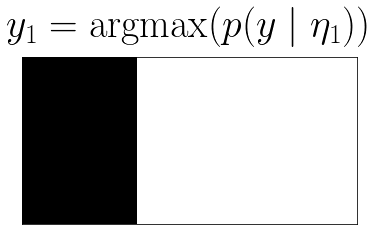

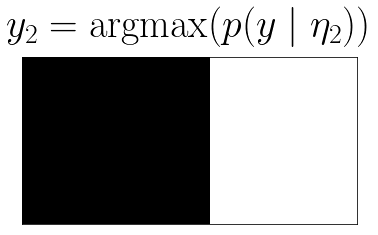

In [15]:
ys_pred = net(torch.as_tensor(inp[:, None, ...]), as_probs=True, n_samples=200).detach().numpy()[0]
plot_im(ys_pred[0] > 0.5, cmap="gray", title=r"$$y_1 = \mathrm{argmax}(p(y \mid \eta_1))$$")
plot_im(ys_pred[1] > 0.5, cmap="gray", title=r"$$y_2 = \mathrm{argmax}(p(y \mid \eta_2))$$")

Verfiy that the average of all samples resembles the average of all ground truth labels.

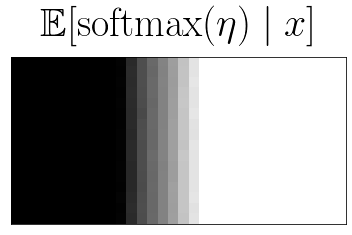

In [16]:
plot_im(ys_pred.mean(0), cmap="gray", title="$$\mathbb{E}[\mathrm{softmax}(\eta)\mid x]$$")

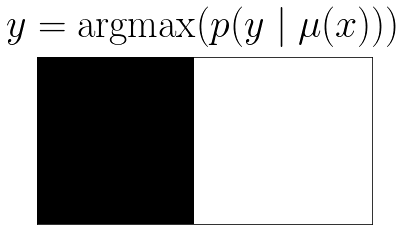

In [18]:
mode_pred = net(torch.as_tensor(inp[:, None, ...]), as_probs=True, use_mode=True).detach().numpy()
plot_im(mode_pred > 0.5, cmap="gray", title=r"$$y = \mathrm{argmax}(p(y \mid \mu(x)))$$")

## Extra: explore the covariance

In [19]:
cf, cd = net.compute_cov(torch.as_tensor(inp[:, None, ...]))

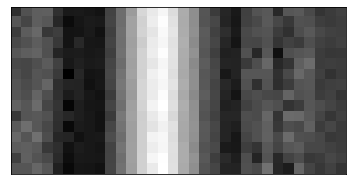

In [20]:
plot_im(cf.view(1, 32, 32, 2).detach().numpy().sum(-1), cmap="gray")

In [21]:
cf = cf.detach().numpy()[0]
cd = cd.detach().numpy()[0]
cov_mat = cf @ cf.T + np.diag(cd)

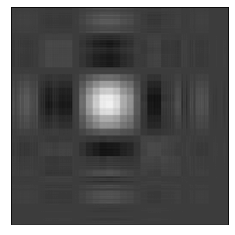

In [23]:
plt.imshow(cov_mat, cmap="gray")
plt.gca().set_xticks([])
plt.gca().set_yticks([])